# Проектная работа: Анализ бизнес-показателей приложения

Перед нами поставлена задача определить причины, по которым компания, выпустившая развлекательное приложение Procrastinate Pro+ терпит убытки. В нашем распоряжении имеются таблицы с данными о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Следует произвести анализ данных, ответить на вопросы маркетингового отдела и дать рекомендации по улучшению бизнес-показателей.

### Загрузим данные и подготовим их к анализу

#### Импортируем нужные библиотеки, изучим данные, проверим пропуски

In [1]:
# Импортируем все необходимые библиотеки:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# Прочитаем данные файлы

In [3]:
visits = pd.read_csv(r'E:\Analytics\visits_info_short.csv')
orders = pd.read_csv(r'E:\Analytics\orders_info_short.csv')
costs =  pd.read_csv(r'E:\Analytics\costs_info_short.csv')

# Сразу преобразуем данные о времени
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [4]:
#Посмотрим таблицу visits
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   User Id        309901 non-null  int64         
 1   Region         309901 non-null  object        
 2   Device         309901 non-null  object        
 3   Channel        309901 non-null  object        
 4   Session Start  309901 non-null  datetime64[ns]
 5   Session End    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [5]:
# Хотя из таблицы выше и видно, что пропусков нет - сделаем проверку:
visits.isna().sum()

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

Пропусков нет, типы данных соответствуют типам данных столбцов. Необходимо откорректировать имена столбцов.

In [6]:
#Посмотрим таблицу orders
orders.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   User Id   40212 non-null  int64         
 1   Event Dt  40212 non-null  datetime64[ns]
 2   Revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Пропусков нет, типы данных соответствуют типам данных столбцов. Необходимо откорректировать имена столбцов.

In [7]:
#Посмотрим таблицу costs
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Пропусков нет, типы данных соответствуют типам данных столбцов. Необходимо откорректировать имена столбцов.

#### Для удобства дальнейшей работы откорректируем имена столбцов:

In [8]:
# Таблица visits
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]
visits.head(3)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08


In [9]:
# Откорректируем именя столбцов в остальных таблицах
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})
orders.head(3)

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99


In [10]:
costs = costs.rename(columns={'Channel':'channel'})
costs.head(3)

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8


#### Проверим таблицы на дубликаты:

In [11]:
visits.duplicated().sum()

0

In [12]:
orders.duplicated().sum()

0

In [13]:
costs.duplicated().sum()

0

Вывод: таблицы откорректированы, типы данных изменены, проверки выполнены. Таблицы готовы к работе.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.


Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### Для расчета и анализа и LTV, ROI, удержания и конверсии зададим необходимые функции:

Функция для создания профилей пользователей get_profiles()

In [14]:
def get_profiles(sessions, orders, costs, dimensions=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функция для расчёта удержания:

In [15]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта конверсии:

In [16]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта LTV и ROI:

In [17]:
def get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
       orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
    

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функции для построения графиков:

In [18]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [19]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [20]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [21]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм',fontsize=16)
    plt.title('LTV',fontsize=16)
    plt.tick_params(labelsize=14)

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения',fontsize=16)
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon),fontsize=16)
    plt.tick_params(labelsize=14)

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения',fontsize=16)
    plt.title('Динамика стоимости привлечения пользователей',fontsize=16)
    plt.tick_params(labelsize=14)

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм',fontsize=16)
    plt.title('ROI',fontsize=16)
    plt.tick_params(labelsize=14)

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения',fontsize=16)
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon),fontsize=16)
    plt.tick_params(labelsize=14)

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построем таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построем таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построем таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируем выводы.

#### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей:

In [22]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [23]:
# Минимальная дата привлечения пользователей:
profiles['first_ts'].min() 

Timestamp('2019-05-01 00:00:41')

In [24]:
# Максимальная дата привлечения пользователей:
profiles['first_ts'].max() 

Timestamp('2019-10-27 23:59:04')

Итого: Пользователи привлекались с 1 мая 2019 по 27 октября 2019 года.

#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.


In [25]:
reg_payers = profiles.groupby('region').agg({'user_id':'nunique','payer':'mean'}).sort_values(by='payer', ascending=False).reset_index()
pd.set_option('display.float_format', '{:.2f}'.format)
reg_payers

,region,user_id,payer
0,United States,100002,0.07
1,Germany,14981,0.04
2,UK,17575,0.04
3,France,17450,0.04


In [26]:
# Для наглядности построим круговую диаграмму:

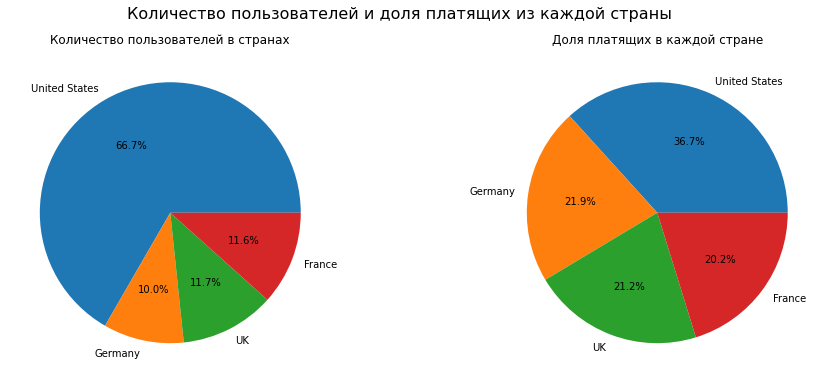

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,6))
labels = reg_payers['region'].tolist()

reg_payers.plot.pie(ax=ax[0], y='user_id', autopct='%1.1f%%', labels=labels, normalize = True)
reg_payers.plot.pie(ax=ax[1], y='payer', autopct='%1.1f%%', labels=labels, normalize = True)

fig.suptitle('Количество пользователей и доля платящих из каждой страны', fontsize= 16)            

ax[0].set(xlabel='', ylabel='',title='Количество пользователей в странах')
ax[1].set(xlabel='', ylabel='', title='Доля платящих в каждой стране')

ax[0].get_legend().remove()
ax[1].get_legend().remove()


plt.show()

Больше всего новых пользователей превращаются в "платящих" в США. Меньше всего во Франции.

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [28]:
dev_payers = profiles.groupby('device').agg({'user_id':'nunique','payer':'mean'}).sort_values(by='user_id', ascending=False).reset_index() 
dev_payers

,device,user_id,payer
0,iPhone,54479,0.06
1,Android,35032,0.06
2,PC,30455,0.05
3,Mac,30042,0.06


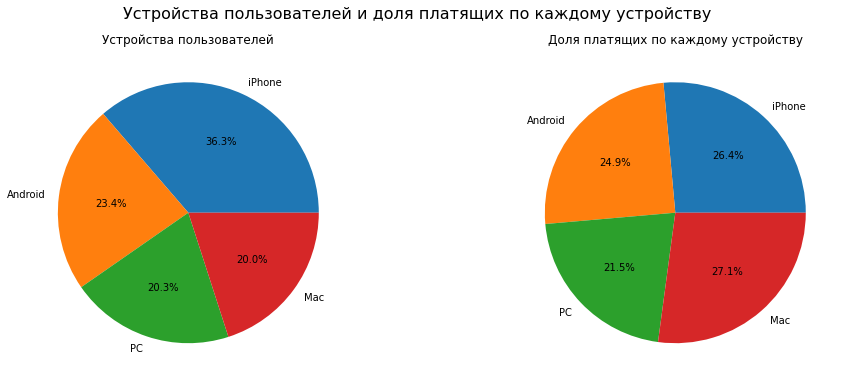

In [29]:
# Визуализируем устройства:

fig, ax = plt.subplots(1,2, figsize=(16,6))
labels = dev_payers['device'].tolist()

dev_payers.plot.pie(ax=ax[0], y='user_id', autopct='%1.1f%%', labels=labels, normalize = True)
dev_payers.plot.pie(ax=ax[1], y='payer', autopct='%1.1f%%', labels=labels, normalize = True)
 
fig.suptitle('Устройства пользователей и доля платящих по каждому устройству', fontsize= 16)            

ax[0].set(xlabel='', ylabel='',title='Устройства пользователей')
ax[1].set(xlabel='', ylabel='', title='Доля платящих по каждому устройству')

ax[0].get_legend().remove()
ax[1].get_legend().remove()


plt.show()

Чаще всего клиенты заходят с iPhone, реже всего с Маков. При этом Маковские пользователи чаще всего становятся платящими.

#### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [30]:
chan_payers = profiles.groupby('channel').agg({'user_id':'nunique','payer':'mean'}).sort_values(by='user_id', ascending=False).reset_index()
chan_payers

,channel,user_id,payer
0,organic,56439,0.02
1,FaceBoom,29144,0.12
2,TipTop,19561,0.10
3,OppleCreativeMedia,8605,0.03
4,LeapBob,8553,0.03
5,WahooNetBanner,8553,0.05
6,RocketSuperAds,4448,0.08
7,MediaTornado,4364,0.04
8,YRabbit,4312,0.04
9,AdNonSense,3880,0.11


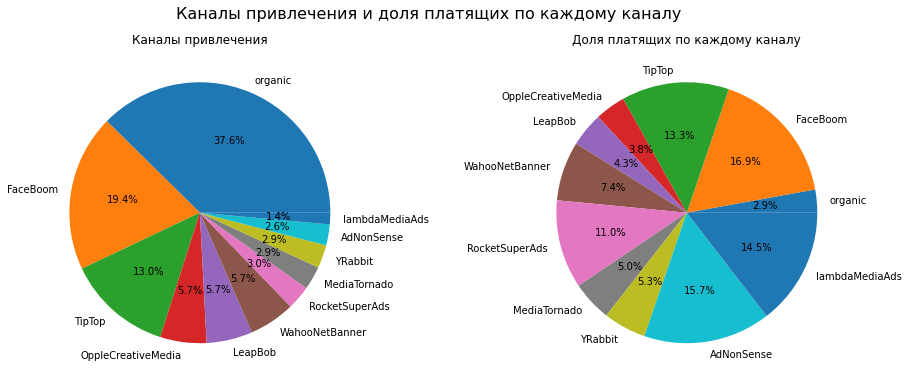

In [31]:
# Визуализируем каналы привлечения:

fig, ax = plt.subplots(1,2, figsize=(16,6))
labels = chan_payers['channel'].tolist()

chan_payers.plot.pie(ax=ax[0], y='user_id', autopct='%1.1f%%', labels=labels, normalize = True)
chan_payers.plot.pie(ax=ax[1], y='payer', autopct='%1.1f%%', labels=labels, normalize = True)
 
fig.suptitle('Каналы привлечения и доля платящих по каждому каналу', fontsize= 16)            

ax[0].set(xlabel='', ylabel='',title='Каналы привлечения')
ax[1].set(xlabel='', ylabel='', title='Доля платящих по каждому каналу')

ax[0].get_legend().remove()
ax[1].get_legend().remove()


plt.show()

Пользователей, которые не используют рекламные ссылки - больше всего, и почти в 2 раза больше, чем пользователей от второго канала привлечения.  При этом чаще всего платящими становятся становятся пользователи из источника FaceBoom. Меньше всего конверсия в платящих пользователей у органиков.

 - Мы посмотрели на базовые значения конверсии пользователей в покупатели по регионам, устройствам и каналу привлечения;
 - Определили основной рынок. Получается, что больше всего приходит пользователей из США и они лучше других конвертируется;
 - При этом большая часть пользователей заходит с мобильных устройств, это тоже стоит отметить;
 - Также, мы можем сказать, что наибольшую конверсию имеют пользователи, которые пользуются Mac, а затем следуют пользователи iPhone, т.е. мы можем сказать, что в целом пользователи Apple имеют лучшую конверсию в покупателей. 

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

#### Посчитаем общую сумму расходов на маркетинг.

In [32]:
costs['costs'].sum().round(2)

105497.3

Всего на рекламную кампанию было потрачено 105497,3 усл. единиц.

#### Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.

In [33]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Самые большие инвестиции ушли в TipTop и FaceBoom, меньше всего потрачено на YRabbit.

#### Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Отразим это на одном графике.

In [34]:
# Для начала построим таблицу с информацией о разбивке расходов по неделям и месяцам, 
# для этого выделем недели и месяцы из исходной таблицы

costs['dt'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['dt'].dt.isocalendar().week 
costs['month'] = costs['dt'].dt.month
costs.head()


,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.30,18,5
1,2019-05-02,FaceBoom,78.10,18,5
2,2019-05-03,FaceBoom,85.80,18,5
3,2019-05-04,FaceBoom,136.40,18,5
4,2019-05-05,FaceBoom,122.10,18,5


In [35]:
# Для построения графиков нам понадобятся таблицы
# Таблица с раходами по неделям
costs_weekly = costs.pivot_table(index='week', columns = 'channel', values='costs', aggfunc='sum')

In [36]:
# Таблица с раходами по месяцам
costs_monthly = costs.pivot_table(index='month', columns = 'channel', values='costs', aggfunc='sum')

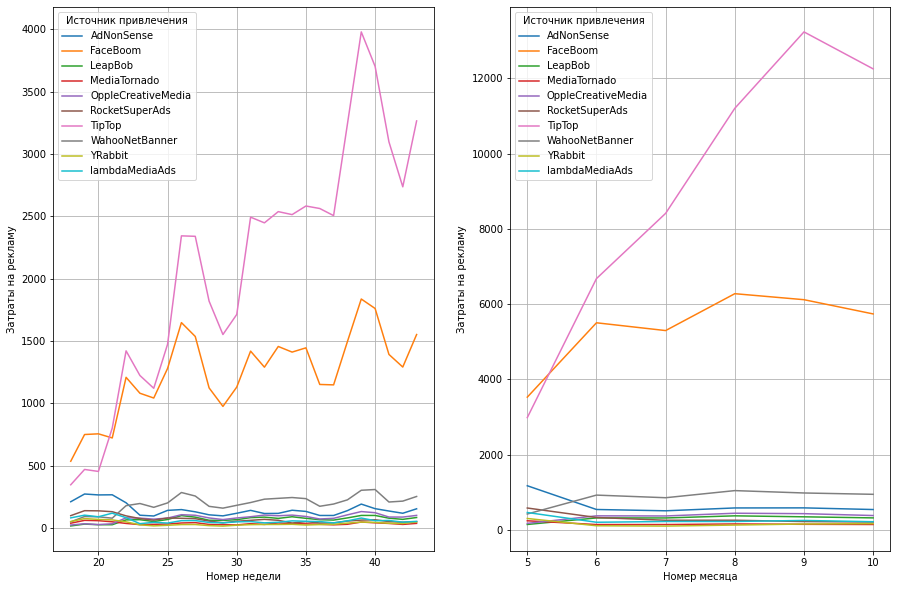

In [37]:
# Визуализация:

plt.figure(figsize=(15, 10))
ax1=plt.subplot(1,2,1)
costs_weekly.plot(grid=True, ax=ax1)
plt.legend(title='Источник привлечения')
plt.xlabel('Номер недели')
plt.ylabel('Затраты на рекламу')


ax2=plt.subplot(1,2,2)
costs_monthly.plot(grid=True, ax=ax2)
plt.legend(title='Источник привлечения')
plt.xlabel('Номер месяца')
plt.ylabel('Затраты на рекламу')
plt.show()


Абсолютный лидер по тратам на рекламу - канал TipTop, следом идут FaceBoom и WahooNetBanner.

#### Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [38]:
 profiles.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самые дорогие клиенты пришли из источников TipTop и FaceBoom. Меньше всего "стоят" пользователи из LeapBob.

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

#### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графиков динамики LTV, CAC и ROI.

In [39]:
# Зададим момент и горизонт анализа. Применим написанную ранее фцнкцию для расчета LTV. 

profiles = profiles.query('channel != "organic"') # Удаляем из расчетов "органических" клиентов

observation_date = datetime(2019, 11, 1).date()  # момент анализа 
horizon_days = 14  # горизонт анализа 

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days,dimensions=[])


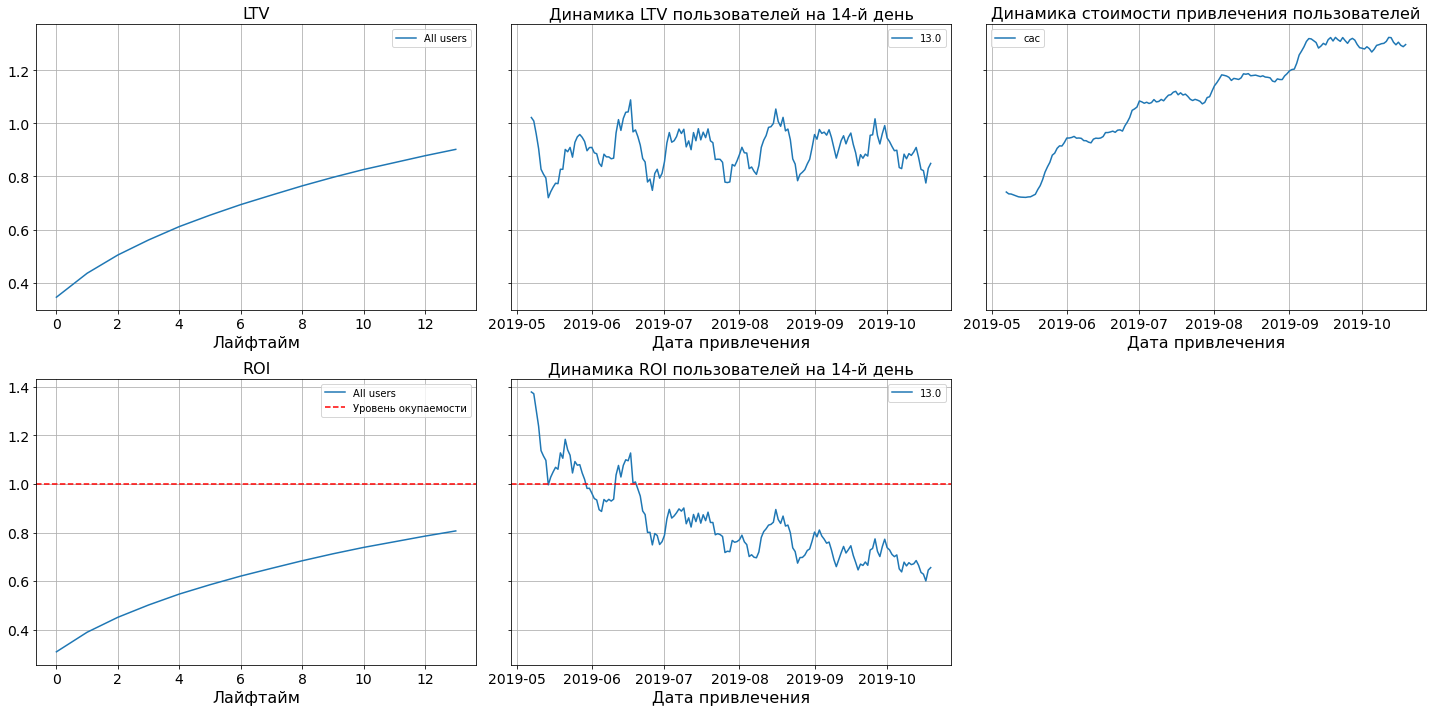

In [40]:
# Постороим графики LTV и ROI, для этого вызовем функцию для визуализации LTV и ROI.

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

По графикам можно сделать такие выводы:
- Кривая LTV плавно растёт - значит анализ произведен верно.
- Реклама не окупается. ROI к дате анализа ниже порога окупаемости. По динамике ROI - видим снижение за весь вериод привлечения клиентов.
- CAC растет. Значит, дело не в увеличении рекламного бюджета.
- На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.
Чтобы разобраться в причинах, пройдём по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

  
* Рост `CAC` не всегда связан с увеличением рекламного бюджета, это может быть увеличение конкуренции, изменение подбираемой аудитории 
* В некоторых графиках прослеживаются странные паттерны, которые необычны для метрик, например изменение CAC в динамике, ниже нам удастся найти причину этой аномалии, но здесь можно отметить, что такую странность удалось заметить, это не просто повышение, а многократные скачки, которые кстати связаны с одним крупным каналом)

#### Проверим конверсию пользователей и динамику её изменения. Также изучим удержание пользователей. Построим и изучим графики конверсии и удержания.

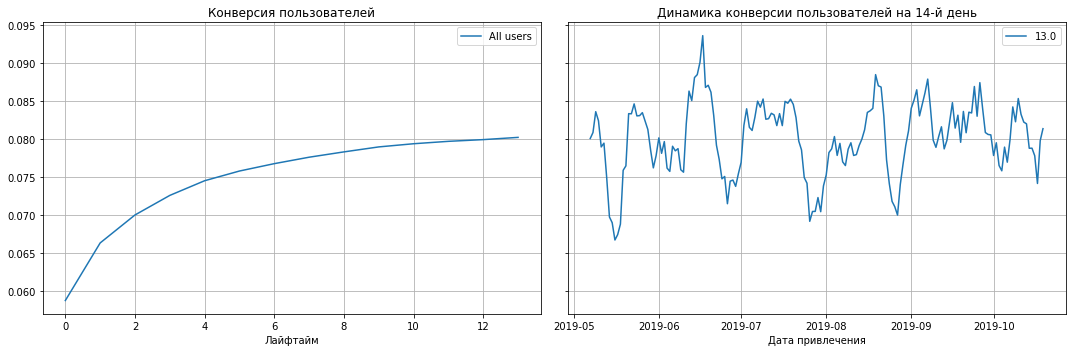

In [41]:
# Функция для расчета и постороения конверсии и динамики конверсии:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)


plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, клиенты конвертируются неплохо и динамика конверсии хорошая.  Оценим удержание клиентов.

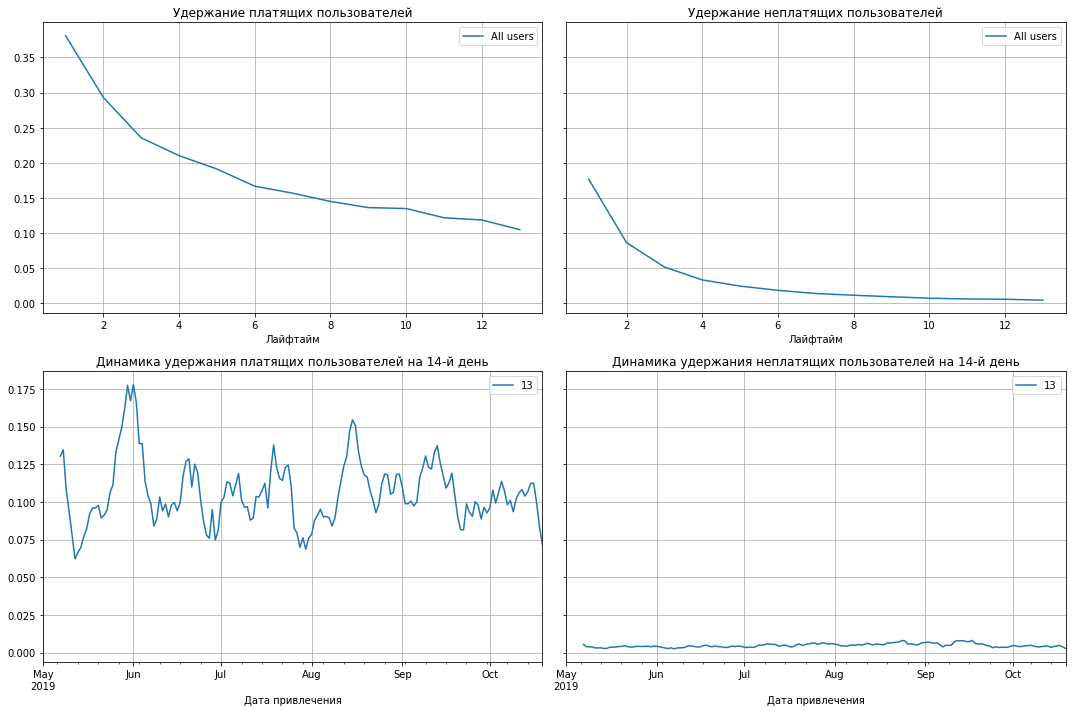

In [42]:
# Функция для расчета удержания и динамики удержания:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)


plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи стабильно плохо удерживаются. Нужно найти причину таких низким показателей.

##### Для полноты картины изучим конверсию и удержание клиентов в зависимости от устройств и региона :

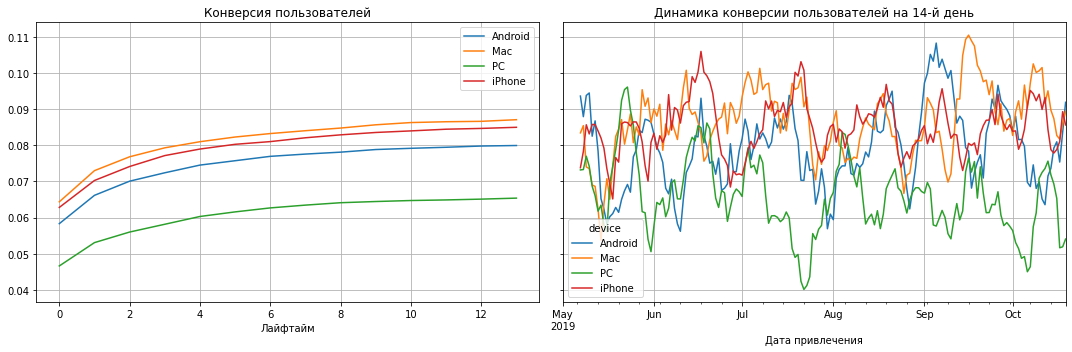

In [43]:
# Конверсия по устройствам:

dimensions= ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

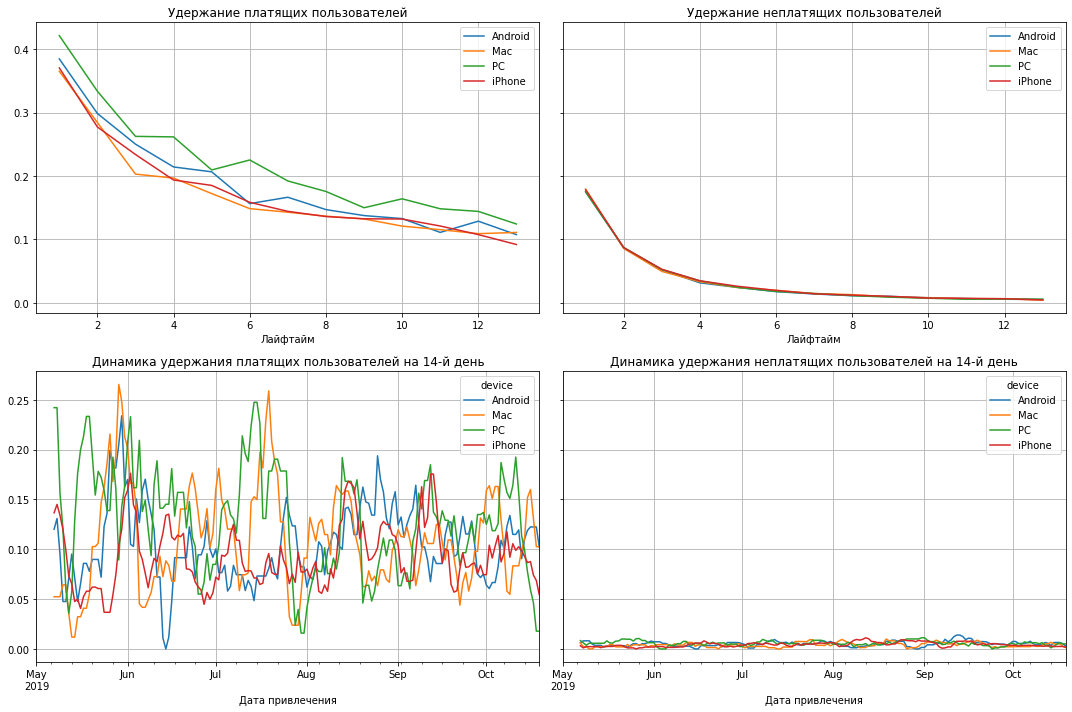

In [44]:
# Удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Самая высокая конверсия у пользователей Mac и iPhone. Самая низкая у пользователей РС. При этом общее удержание всех клиентов стабильно снижается.

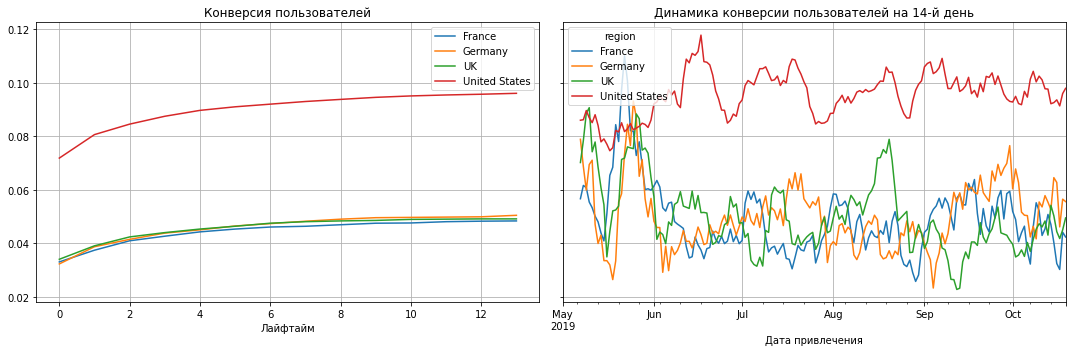

In [45]:
# Конверсия по региону:

dimensions= ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

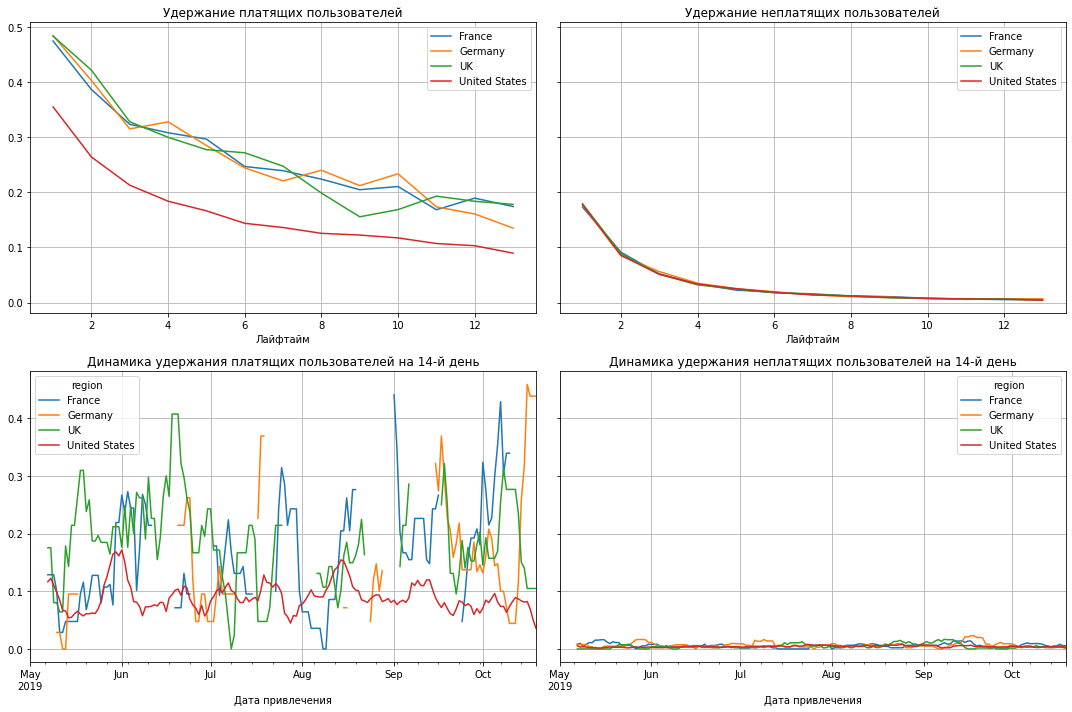

In [46]:
# Удержание по региону

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

В отношении конверсии по региону видим следующее: самая высокая конверсия у клиентов из США, при этом именно в этой стране самое низкое удержание клиентов. Таким образом, самые платящие клиенты хуже всего удерживаются. Возможная причина -  техническая ошибка для этих пользователей.

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

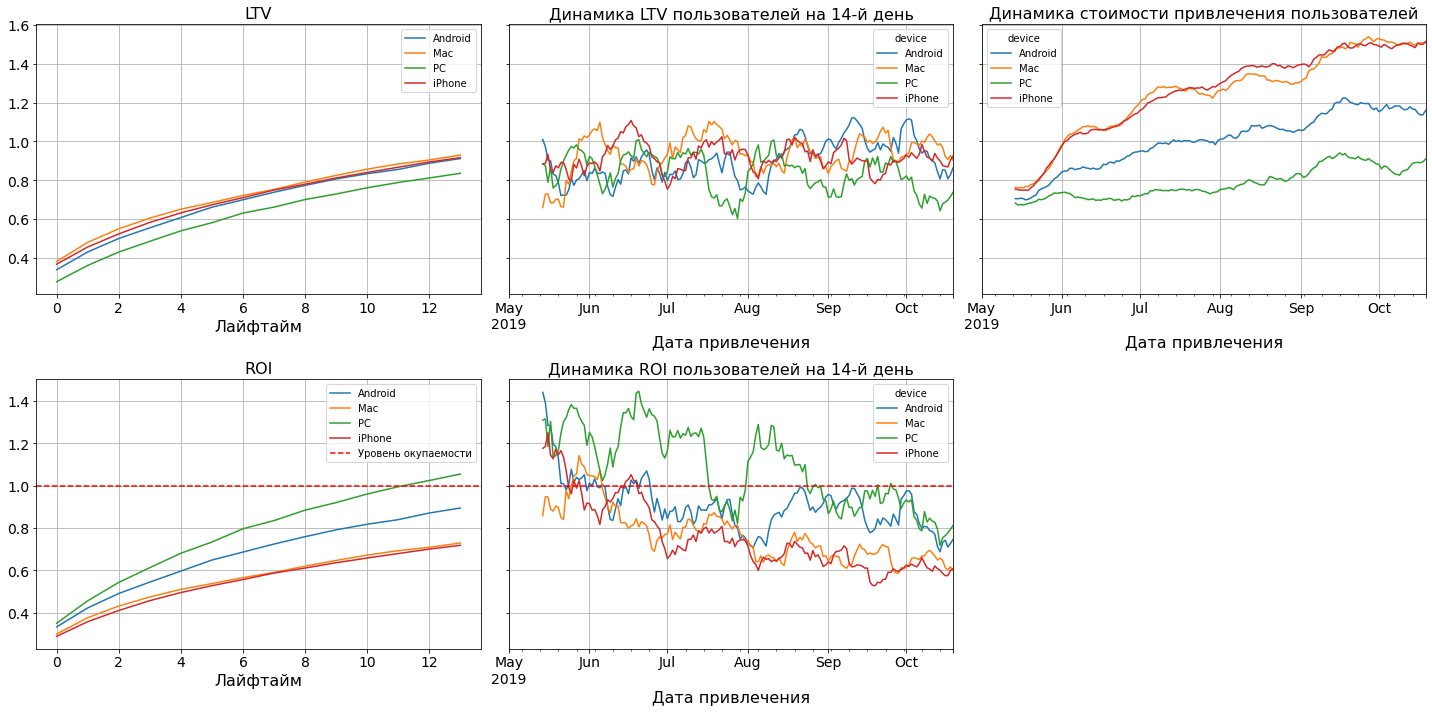

In [47]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Пользователи PC и Android окупаются, в то время как пользователи iPhone и Mac - нет. Помимо общего низкого удержания возможна какая-то техническая ошибка.

#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

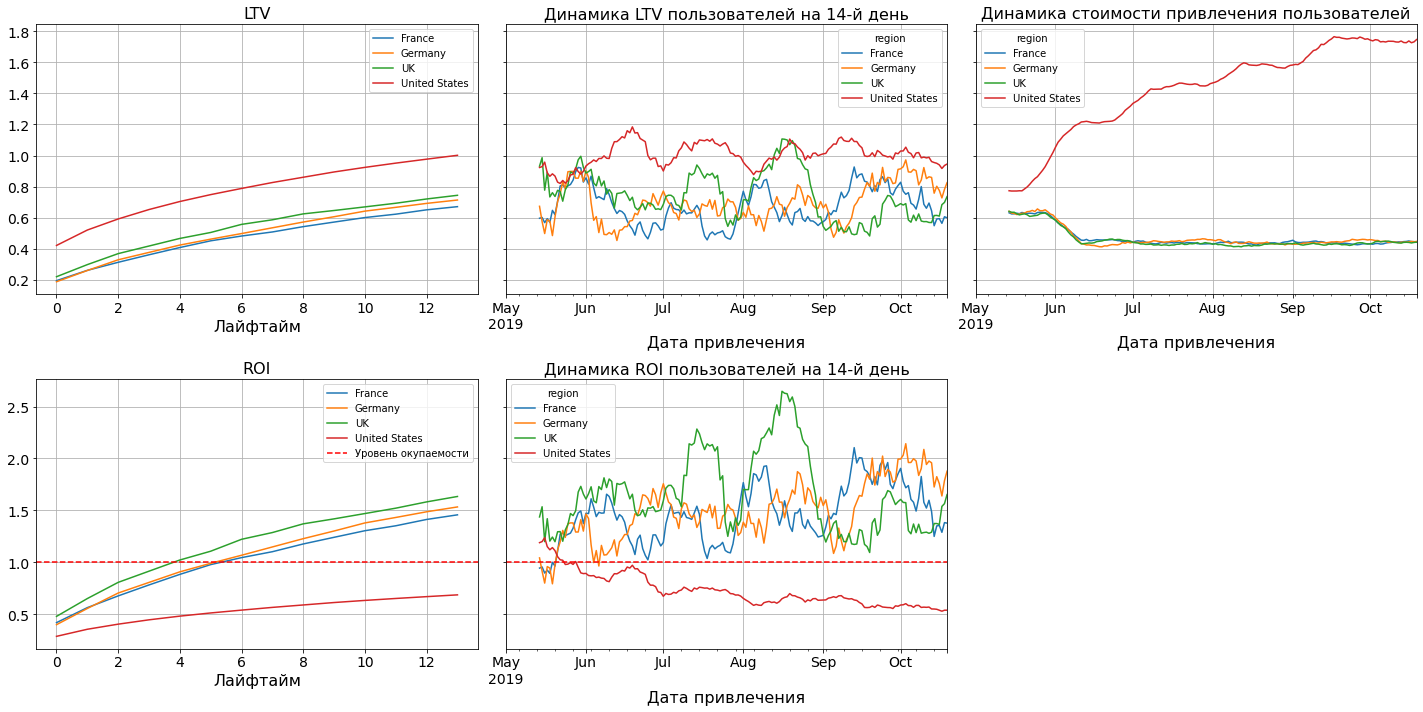

In [48]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам видно следующее: 
- LTV стабильно растет во всех региаонах, и США в лидерах.
- Стоимость привлечения стабильна для всех регионов, кроме США. Здесь стоимость увеличивается в разы.
- Реклама не окупается только в США! Динамика ROI в остальных регионах хорошая.
- Лучше всего окупается Великобритания.

С США явные проблемы...

####  Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

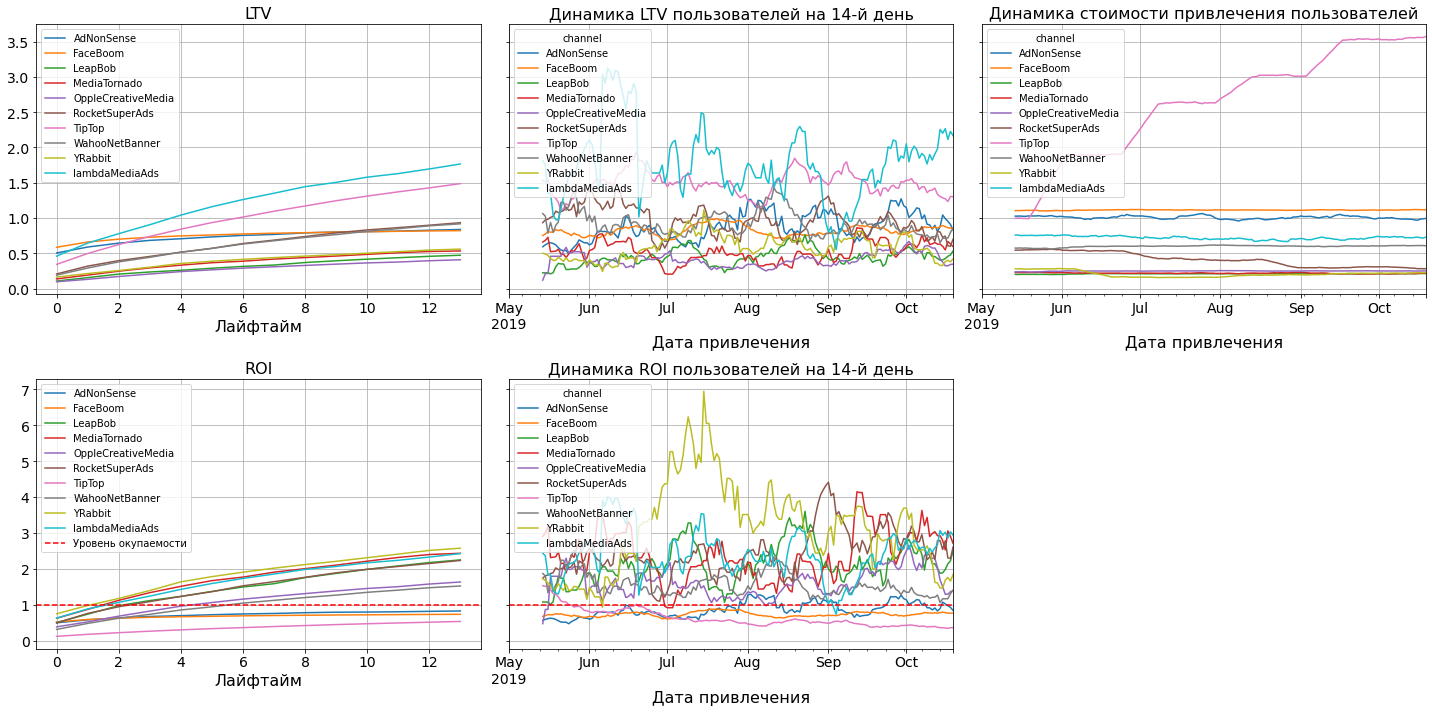

In [49]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Анализируя графики, видим следующее:
- LTV растет. Самый высокий рост демонстрируют клиенты, пришедшие из источников lambdaMediaAds и TipTop.
- Все каналы показывают стабильный CAC, кроме канала TipTop. С течением времени наблюдаем почти линейный рост стоимости привлечения клиентов по этому каналу.
- Реклама окупается у всех каналов, кроме TipTop, FaceBoom и AdNonSense, причем у TipTop самые худшие показатели. 
    

#### Проведя данное исследование, можем ответить на следующие вопросы:
 - Окупается ли реклама, направленная на привлечение пользователей в целом?
 
В целом реклама на привлечение пользователей не окупается. Возможно стоит пересмотреть заинтересованность в канале TipTop, так как вложения в этот канал в разы превосходят вложения в другие каналы, при этом до окупаемости очень далеко. А также решить проблему с пользователями Mac и iPhone из США.
 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?

Как уже было сказано выше в отношении рекламных каналов, вложения в каналы TipTop, FaceBoom и AdNonSense не окупаются. Касательно устройств - не окупается реклама для устройств Mac и iPhone. В отношении региона - хуже всего дела в США.

- Чем могут быть вызваны проблемы окупаемости?

С учетом того, что основные проблемы у пользователей Mac и iPhone из США, можем сделать вывод о технической ошибке приложения на данной системе в этой стране.

#### Проведем дополнительную проверку для США:

In [50]:
usa = profiles.query('region=="United States"')

# Проверим, какими в основном устройствами пользуются в США

usa.groupby('device').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)


,user_id
device,
iPhone,27548
Mac,15424
Android,12436
PC,6421


В самой проблемной стране - самые популярные устройства - самые проблемные в отношении окупаемости.

In [51]:
usa.groupby('channel').agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)

,user_id
channel,
FaceBoom,29144
TipTop,19561
RocketSuperAds,4448
MediaTornado,4364
YRabbit,4312


Самые популярные каналы в США те, которые хуже всех окупаются. Маркетологи, желая привлечь клиентов из США, вкладывали большие деньги в самые популярные каналы там, при этом реклама тут не сработает.

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

#### В ходе выполнения работы по выяснению причин убытков компании и приложения Procrastinate Pro+ были изучены следующие вопросы:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов,
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

Для корректного анализа и получения реальной картины было принято решение не учитывать пользователей, перешедших в приложение "органическим" способом. Данные этих пользователей могли внести искажения в расчеты.

- Причины неэффективности привлечения пользователей:

Было выяснено, что клиенты по всему миру охотно пользуются приложением и рекламная компания окупается везде, кроме одной страны - США. В этой стране самое больше количество клиентов, самая высокая конверсия, но при этом и самое низкое удержание. Затраты на рекламу для США превосходят выручку по миру. Вкладывая деньги в рекламу выйти в плюс компании не удалось, потому, что дело в технической ошибке на устройствах  Mac и iPhone в этой стране. 


- В качестве рекомендации для отдела маркетинга можно сообщить следующее:
    
Увеличение рекламного бюджета не приведет к росту выручки компании. Явно присутствует техническая ошибка, снижающая удержание клиентов. Следует проанализировать события и найти причину, по которой пользователи покидают приложение, в особенности пользователи из США.  